In [6]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np

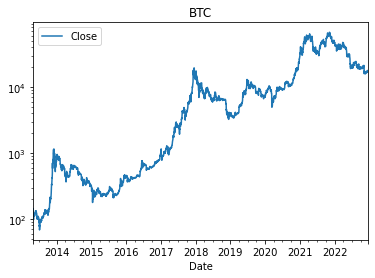

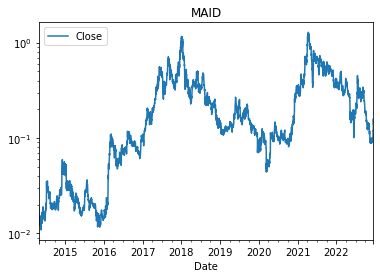

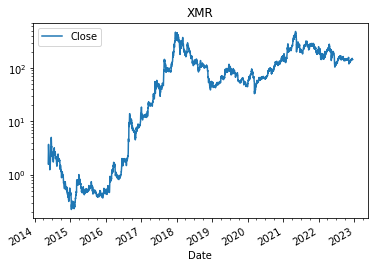

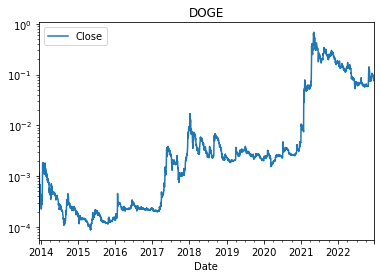

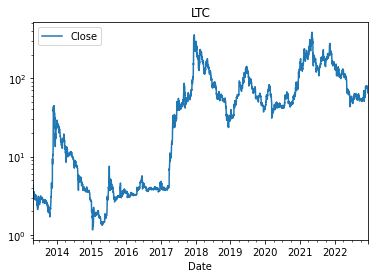

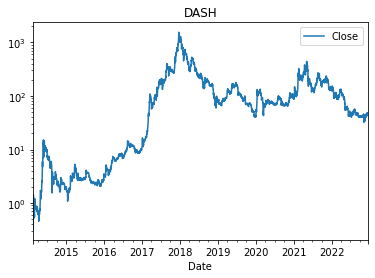

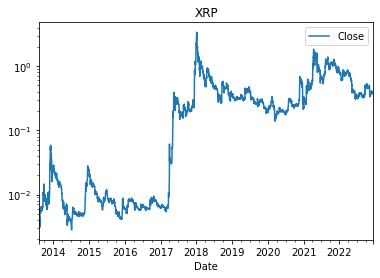

In [3]:
coins = ['BTC', 'MAID', 'XMR', 'DOGE', 'LTC', 'DASH', 'XRP']
for coin in coins:
    df = pd.read_csv(f'https://raw.githubusercontent.com/georgec123/sa_cw/main/data/prices/{coin}.csv').set_index('Date').sort_index()
    df.index = pd.to_datetime(df.index)
    
    ax = df[['Close']].plot(logy=True)
    months = mdates.MonthLocator((1,4,7,10))
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.tick_bottom()
    
    plt.title(coin)
    plt.show()

In [4]:
df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-08-04,0.005874,0.005927,0.005874,0.005882,0.000000e+00,4.598358e+07
2013-08-05,0.005875,0.005980,0.005613,0.005613,0.000000e+00,4.387916e+07
2013-08-06,0.005637,0.005661,0.004629,0.004680,0.000000e+00,3.659101e+07
2013-08-07,0.004669,0.004682,0.004333,0.004417,0.000000e+00,3.453412e+07
2013-08-08,0.004397,0.004424,0.004175,0.004254,0.000000e+00,3.325863e+07
...,...,...,...,...,...,...
2022-12-13,0.387386,0.396085,0.379270,0.395102,1.137293e+09,1.991136e+10
2022-12-14,0.395101,0.395253,0.380863,0.386414,8.932355e+08,1.947350e+10
2022-12-15,0.386387,0.386661,0.375375,0.378237,7.397361e+08,1.906141e+10


In [7]:
#Calculate log returns
df['SimpleReturn']=df['Close'].pct_change()
df['LogReturn']=np.log(1+df['SimpleReturn'])

In [13]:
from scipy.optimize import minimize

## Laplace MLE

In [33]:
# Likelihood function for student-t

def laplace_loglikelihood(mu,b,x):
    n=len(x)
    return -n*np.log(2*b)-np.sum(np.abs(x-mu)/b)

x=df['LogReturn'].dropna()

objfun=lambda theta : -1*laplace_loglikelihood(theta[0],theta[1],x) #function to minimise

bnds=((-np.inf,np.inf), (0,np.inf)) #bounds on parameters

init_theta=[np.mean(x),1]

sol=minimize(objfun,init_theta, method='SLSQP',bounds=bnds)
print("Estimate of mu:",sol.x[0])
print("Estimate of b:",sol.x[1])

Estimate of mu: -0.001679365596901997
Estimate of b: 0.039735417369717474


C:\Users\david\AppData\Local\Temp\ipykernel_10796\1513414755.py:5: RuntimeWarning: divide by zero encountered in log
  return -n*np.log(2*b)-np.sum(np.abs(x-mu)/b)
C:\Users\david\AppData\Local\Temp\ipykernel_10796\1513414755.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return -n*np.log(2*b)-np.sum(np.abs(x-mu)/b)


Theoretical MLE of mu: -0.001675653170908161
Theoretical MLE of b: 0.03973543711525389


In [35]:
def laplace_loglikelihood(mu,b,x):
    n=len(x)
    return -n*np.log(2*b)-np.sum(np.abs(x-mu)/b)

x=df['LogReturn'].dropna()

def laplace_MLE(x):
    objfun=lambda theta : -1*laplace_loglikelihood(theta[0],theta[1],x) #function to minimise

    bnds=((-np.inf,np.inf), (0,np.inf)) #bounds on parameters

    init_theta=[np.mean(x),1]

    sol=minimize(objfun,init_theta, method='SLSQP',bounds=bnds)
    print("Estimate of mu:",sol.x[0])
    print("Estimate of b:",sol.x[1])
    
    print("Theoretical MLE of mu:",np.median(x))
    print("Theoretical MLE of b:", np.mean(np.abs(x-np.median(x))))
    
    return sol.x

In [36]:
laplace_MLE(x)

Estimate of mu: -0.001679365596901997
Estimate of b: 0.039735417369717474
Theoretical MLE of mu: -0.001675653170908161
Theoretical MLE of b: 0.03973543711525389


C:\Users\david\AppData\Local\Temp\ipykernel_10796\1849457968.py:3: RuntimeWarning: divide by zero encountered in log
  return -n*np.log(2*b)-np.sum(np.abs(x-mu)/b)
C:\Users\david\AppData\Local\Temp\ipykernel_10796\1849457968.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return -n*np.log(2*b)-np.sum(np.abs(x-mu)/b)


array([-0.00167937,  0.03973542])

## Skew t

In [ ]:
import scipy.stats as stats

In [181]:
'''
STATISTICAL INFERENCE FOR A NEW CLASS OF SKEW T DISTRIBUTION AND ITS
RELATED PROPERTIES - Doaa Basalamah -Page 9

https://etd.ohiolink.edu/apexprod/rws_etd/send_file/send?accession=bgsu1496762068499547&disposition=inline

mu-mean
sigma-std. deviation
nu-degrees of freedom
lmda-skewness parameter
'''


def skewt_pdf(x,mu,sigma,nu,lmda):
    return (2/sigma*stats.t.pdf(x-mu/sigma,df=nu)*
            stats.t.cdf(lmda* (x-mu)/sigma *np.sqrt( (nu+1)/(((x-mu)/sigma)**2 + nu) ) ,df=nu+1))

def skewt_loglikelihood(mu,sigma,nu, lmda,x):
    return np.sum(np.log(skewt_pdf(x,mu,sigma,nu,lmda)))


In [196]:
def skewt_MLE(x):
    objfun= lambda theta: -1*skewt_loglikelihood(theta[0],theta[1],theta[2],theta[3],x)
    
    bnds=((-np.inf,np.inf), (0,np.inf), (0,np.inf), (-np.inf,np.inf) ) #bounds on parameters

    init_theta=[np.mean(x),0.05,1,1]

    sol=minimize(objfun,init_theta, method='SLSQP',bounds=bnds)
    print("Estimate of mu:",sol.x[0])
    print("Estimate of sigma:",sol.x[1])
    print("Estimate of nu",sol.x[2])
    print("Estimate of lambda",sol.x[3])
    return sol

In [197]:
skewt_MLE(x)

C:\Users\david\AppData\Local\Temp\ipykernel_10796\3352016893.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  return 2/sigma*stats.t.pdf(x-mu/sigma,df=nu)*stats.t.cdf(lmda*(x-mu)/sigma*np.sqrt((nu+1)/( ((x-mu)/sigma)**2 + nu) ) ,df=nu+1)
C:\Users\david\AppData\Local\Temp\ipykernel_10796\3352016893.py:8: RuntimeWarning: invalid value encountered in multiply
  return 2/sigma*stats.t.pdf(x-mu/sigma,df=nu)*stats.t.cdf(lmda*(x-mu)/sigma*np.sqrt((nu+1)/( ((x-mu)/sigma)**2 + nu) ) ,df=nu+1)
C:\Users\david\AppData\Local\Temp\ipykernel_10796\3352016893.py:11: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(skewt2(x,mu,sigma,nu,lmda)))


Estimate of mu: -0.041845628545560606
Estimate of sigma: 0.08259477099395866
Estimate of nu 16.358569619129252
Estimate of lambda 2.368608753996268


     fun: -5493.312933475894
     jac: array([1.60819823e+04, 2.43202908e+04, 7.94744873e+00, 2.73141846e+02])
 message: 'Optimization terminated successfully'
    nfev: 279
     nit: 41
    njev: 37
  status: 0
 success: True
       x: array([-0.04184563,  0.08259477, 16.35856962,  2.36860875])

Attempting direct implementation of pdf in the paper, didn't work for me

In [ ]:
#equals skewnorm*(chisquare/df)^-1/2
# according to Azzaini and Capitanio pg 15

In [37]:
import scipy.stats as stats

In [43]:
'''
def skewt_pdf(x,a,nu,loc,scale):
    implements pdf of the skew-t distribution as the ratio of skewnorm and chi-square 
    

0.408301253966056

In [52]:
import math as m
from scipy.special import hyp2f1, beta #gauss hypergeometric functi

In [126]:
'''
def Kappa(nu):
    return np.sqrt(nu)*beta(nu/2,1/2)

def skewt_pdf(x,mu,sigma,nu,lmda):
    return (Kappa(nu)/sigma * ((1+(x-mu)**2)/(sigma**2*nu))**(-(1 + nu)/2) + 2*Kappa(nu)**2*lmda*(x-mu)/sigma**2 * 
           hyp2f1(1/2, (1+nu)/2, 3/2, -lmda**2*(x-mu)**2/(sigma**2*nu) ))

def skewt_loglikelihood(mu,sigma,nu, lmda,x):
    return np.sum(np.log(skewt_pdf(x,mu,sigma,nu,lmda)))

In [133]:
'''
def Kappa(nu):
    return np.sqrt(nu)*beta(nu/2,1/2)

def skewt_pdf(x,mu,sigma,nu,lmda):
    return Kappa(nu)/sigma * ( 1+(x-mu)**2/(sigma**2*nu))**(-(1 + nu)/2) + 2*Kappa(nu)**2*lmda*(x-mu)/sigma**2 * hyp2f1(1/2, (1+nu)/2, 3/2, -1*lmda**2*(x-mu)**2/(sigma**2*nu) )

def skewt_loglikelihood(mu,sigma,nu, lmda,x):
    return np.product(skewt_pdf(x,mu,sigma,nu,lmda))

In [130]:
'''
#MLE estimation
def skewt_MLE(x):
    objfun= lambda theta: -1*skewt_loglikelihood(theta[0],theta[1],theta[2],theta[3],x)
    
    bnds=((-np.inf,np.inf), (0,np.inf), (0,np.inf), (-np.inf,np.inf) ) #bounds on parameters

    init_theta=[np.mean(x),0.1,0.1,0.1]

    sol=minimize(objfun,init_theta, method='SLSQP',bounds=bnds)
    print("Estimate of mu:",sol.x[0])
    print("Estimate of sigma:",sol.x[1])
    print("Estimate of nu",sol.x[2])
    print("Estimate of lambda",sol.x[3])
    return sol

In [150]:
skewt_pdf(x,np.mean(x),1,1,1)

Date
2013-08-05    2.186759
2013-08-06   -0.529621
2013-08-07    1.966373
2013-08-08    2.370746
2013-08-09    3.288472
                ...   
2022-12-13    3.505746
2022-12-14    2.677379
2022-12-15    2.694224
2022-12-16    1.684095
2022-12-17    3.275420
Name: LogReturn, Length: 3422, dtype: float64

In [161]:
mu=np.mean(x)
sigma=1
lmda=1
nu=1

In [169]:
2*Kappa(nu)**2*lmda*(x-mu)/sigma**2 #* hyp2f1(1/2, (1+nu)/2, 3/2, -1*lmda**2*(x-mu)**2/(sigma**2*nu))

Date
2013-08-05   -0.948328
2013-08-06   -3.609019
2013-08-07   -1.165654
2013-08-08   -0.766502
2013-08-09    0.147057
                ...   
2022-12-13    0.365270
2022-12-14   -0.462574
2022-12-15   -0.445843
2022-12-16   -1.443354
2022-12-17    0.133974
Name: LogReturn, Length: 3422, dtype: float64

# Generalized Student t

In [227]:
def generalized_t_pdf(x,mu,sigma,nu,tao):
    return tao/ (2*sigma*nu**(1/tao) * beta(nu,1/tao))*(1+ 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))

#note there is a typo in the crypto paper nu^(1/nu)should be nu^(1/tao) see:
#Partially Adaptive Estimation of Regression Models via the Generalized t Distribution
#https://www.jstor.org/stable/pdf/3532334.pdf?refreqid=excelsior%3Aa38225d25a3455f71c34f90dcd393cf8&ab_segments=&origin=&acceptTC=1

def generalized_t_loglikelihood(mu,sigma,nu,tao,x):
    return np.sum(np.log(generalized_t_pdf(x,mu,sigma,nu,tao)))

In [233]:
def generalized_t_mle(x):
    objfun= lambda theta: -1*generalized_t_loglikelihood(theta[0],theta[1],theta[2],theta[3],x)
    
    bnds=((-np.inf,np.inf), (0,np.inf), (0,np.inf), (0,np.inf) ) #bounds on parameters

    init_theta=[np.mean(x),np.std(x,ddof=1),1,1]

    sol=minimize(objfun,init_theta, method='SLSQP',bounds=bnds)
    print("Estimate of mu:",sol.x[0])
    print("Estimate of sigma:",sol.x[1])
    print("Estimate of nu",sol.x[2])
    print("Estimate of tao",sol.x[3])
    return sol

In [229]:
generalized_t_loglikelihood(np.mean(x),np.std(x),1,1,x)

4160.603349172445

In [234]:
generalized_t_mle(x)

Estimate of mu: -0.0019204430582639472
Estimate of sigma: 0.032985453233987584
Estimate of nu 2.3524182604201993
Estimate of tao 1.1923557257412851


C:\Users\david\AppData\Local\Temp\ipykernel_10796\3694686015.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return tao/ (2*sigma*nu**(1/tao) * beta(nu,1/tao))*(1+ 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))
C:\Users\david\AppData\Local\Temp\ipykernel_10796\3694686015.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return tao/ (2*sigma*nu**(1/tao) * beta(nu,1/tao))*(1+ 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))
C:\Users\david\AppData\Local\Temp\ipykernel_10796\3694686015.py:2: RuntimeWarning: overflow encountered in double_scalars
  return tao/ (2*sigma*nu**(1/tao) * beta(nu,1/tao))*(1+ 1/nu * np.abs((x-mu)/sigma)**tao)**(-(nu+1/tao))


     fun: -5400.207209648059
     jac: array([-1.09960938, -0.43664551,  0.00231934,  0.01593018])
 message: 'Optimization terminated successfully'
    nfev: 203
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([-1.92044306e-03,  3.29854532e-02,  2.35241826e+00,  1.19235573e+00])

# Skewed student t

In [238]:
(x>0)*1

Date
2013-08-05    0
2013-08-06    0
2013-08-07    0
2013-08-08    0
2013-08-09    1
             ..
2022-12-13    1
2022-12-14    0
2022-12-15    0
2022-12-16    0
2022-12-17    1
Name: LogReturn, Length: 3422, dtype: int32

In [247]:
def Kappa(nu):
    return np.sqrt(nu)*beta(nu/2,1/2)

def skewed_student_t_pdf(x,mu,sigma,nu,alpha):
    indicator=(x>mu)*1 #switch on if x is greater than mu
    return Kappa(nu)/sigma*(1+1/nu*( (x-mu)/(2*sigma*( alpha*(1-indicator) +(1-alpha)*indicator) ) ))**2

def skewed_student_loglikelihood(mu,sigma,nu,alpha,x):
    return np.sum(np.log(skewed_student_t_pdf(x,mu,sigma,nu,alpha)))

In [248]:
def skewed_student_mle(x):
    objfun= lambda theta: -1*skewed_student_loglikelihood(theta[0],theta[1],theta[2],theta[3],x)
    
    bnds=((-np.inf,np.inf), (0,np.inf), (0,np.inf), (0,1) ) #bounds on parameters

    init_theta=[np.mean(x),np.std(x,ddof=1),1,0.5]

    sol=minimize(objfun,init_theta, method='SLSQP',bounds=bnds)
    print("Estimate of mu:",sol.x[0])
    print("Estimate of sigma:",sol.x[1])
    print("Estimate of nu",sol.x[2])
    print("Estimate of tao",sol.x[3])
    return sol

In [249]:
skewed_student_mle(x)

Estimate of mu: -3564.0438497822247
Estimate of sigma: 0.05664703470477438
Estimate of nu 0.8122185857215598
Estimate of tao 0.5938907052067719


C:\Users\david\AppData\Local\Temp\ipykernel_10796\423665904.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(nu)*beta(nu/2,1/2)
C:\Users\david\AppData\Local\Temp\ipykernel_10796\423665904.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return Kappa(nu)/sigma*(1+1/nu*( (x-mu)/(2*sigma*( alpha*(1-indicator) +(1-alpha)*indicator) ) ))**2


     fun: -92358.92486096964
     jac: array([ 1.91992188e+00,  1.81226201e+05,  9.35544629e+03, -1.68524297e+04])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 8
    njev: 4
  status: 0
 success: True
       x: array([-3.56404385e+03,  5.66470347e-02,  8.12218586e-01,  5.93890705e-01])